# Data Mining Project
### Giorgio Donati, g.donati24@studenti.unipi.it
### Pietro Francaviglia, p.francaviglia1@studenti.unipi.it
#### A.Y. 2021-2022


## Libraries and datasets

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from t3_constants import *
from t3_utility import *

In [2]:
with open(f'{PICKLE_FOLDER}{SELECTED}{USER_DF}.pkl', 'rb') as f:
    u_df = pickle.load(f)

with open(f'{PICKLE_FOLDER}{PURE}{SELECTED}{USER_DF}.pkl', 'rb') as f:
    pure_u_df = pickle.load(f)

In [3]:
u_df

,item_count,item_dist_count,max_items_per_b,price_entropy,max_item_dist_per_b,total_price,basket_count,category_count,shop_count,avg_items_per_basket,avg_baskets_per_d
user_id,,,,,,,,,,,
1,709,580,141,3.806662,123,630951.756741,45,48,30,15.755556,1.250000
2,903,669,158,4.168650,104,723773.163169,66,45,31,13.681818,1.404255
3,397,320,50,3.688879,43,488038.085519,40,41,27,9.925000,1.290323
4,932,680,214,3.891820,157,778783.061807,49,41,28,19.020408,1.400000
5,824,620,94,3.912023,82,699040.663917,50,44,23,16.480000,1.515152
...,...,...,...,...,...,...,...,...,...,...,...
819,610,500,68,3.931826,53,465303.064484,51,48,24,11.960784,1.342105
820,783,581,78,4.043051,66,664045.768047,57,49,28,13.736842,1.583333
821,646,473,77,3.871201,62,516218.782161,48,44,29,13.458333,1.371429


## Predictive labelling

In [4]:
predictive_df = u_df[[ICNT, AIXB, PSUM]]

In [5]:
predictive_df_array, predictive_df = scale_df(predictive_df, 1)
predictive_df['all'] = predictive_df[ICNT] + predictive_df[PSUM] + predictive_df[AIXB]
predictive_df_array, predictive_df = scale_df(predictive_df, 1)

In [6]:
predictive_df[LAB] = rankings(predictive_df['all'],1,8)

predictive_df[LAB] = predictive_df[LAB].map({0:0,1:0,2:0,3:1,4:1,5:1,6:2,7:2})

predictive_df.groupby(LAB).describe()

item_count                                                              \
           count      mean       std       min       25%       50%       75%   
label                                                                          
0          298.0 -0.888201  0.397820 -2.411239 -1.112819 -0.814663 -0.631922   
1          298.0  0.030876  0.373559 -0.958932 -0.252014  0.036524  0.286590   
2          199.0  1.283834  0.850363 -0.151026  0.805958  1.104114  1.520089   

                avg_items_per_basket            ... total_price            \
            max                count      mean  ...         75%       max   
label                                           ...                         
0      0.050951                298.0 -0.772918  ...   -0.559073 -0.002558   
1      1.118541                298.0 -0.001519  ...    0.269947  1.300844   
2      7.216308                199.0  1.159709  ...    1.470140  5.975984   

         all                                                              \
       count      mean       std       min       25%       50%       75%   
label                                                                      
0      298.0 -0.888189  0.351591 -2.185101 -1.117294 -0.839475 -0.589206   
1      298.0  0.006697  0.276161 -0.427699 -0.229902  0.020504  0.238870   
2      199.0  1.320023  0.881304  0.558760  0.785561  1.096835  1.516908   

                 
            max  
label            
0     -0.434293  
1      0.558563  
2      7.336478  

[3 rows x 32 columns]

<AxesSubplot:xlabel='label', ylabel='item_count'>

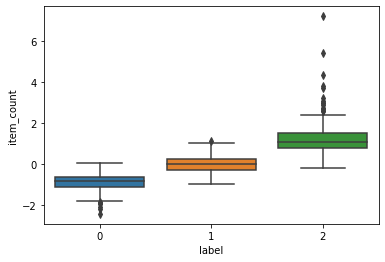

In [7]:
sns.boxplot(x=LAB, y=ICNT, data=predictive_df)